In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

import numpy as np
import pandas as pd
from syn_model import *
%matplotlib inline

## A simple example for illustration

In [3]:
#Load state times series data
_NYTimes_local_path = "../data/covid/NYTimes/"
states = pd.read_csv(_NYTimes_local_path + "us-states.csv")[1:]
cases = states.pivot(index='date', columns='state', values='cases')
cases = cases.fillna(0).iloc[60:]

### Define the parameters and models

In [7]:
target = 'Florida' #Treatment states
donors = list(cases.columns) #donorpools include all other state, 
                             #this is just set for presentation, and not that rigiously chosen
donors.remove(target)
singVals = 3
low_thresh = 100 #This represents the the pre-intervention period, which is the first 100 date of the dataframe
high_thresh = 200 #This is the total time span that we are looking at

model = syn_model(target, singVals, [cases], high_thresh, low_thresh, otherStates = donors) #Create a syn_model object
model.fit_model()#Fit the model

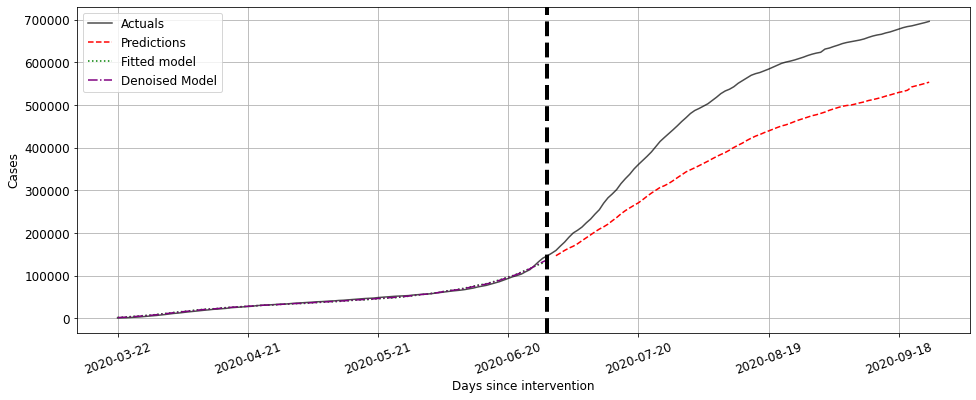

In [10]:
model.plot(show_denoise = True)

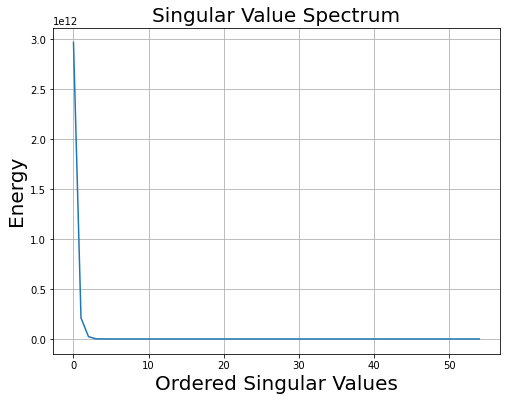

In [5]:
#Check singular value. It seems that 3 is enough
U, s, Vh = model.svd_spectrum(show_plot = True)

### Plot the digram

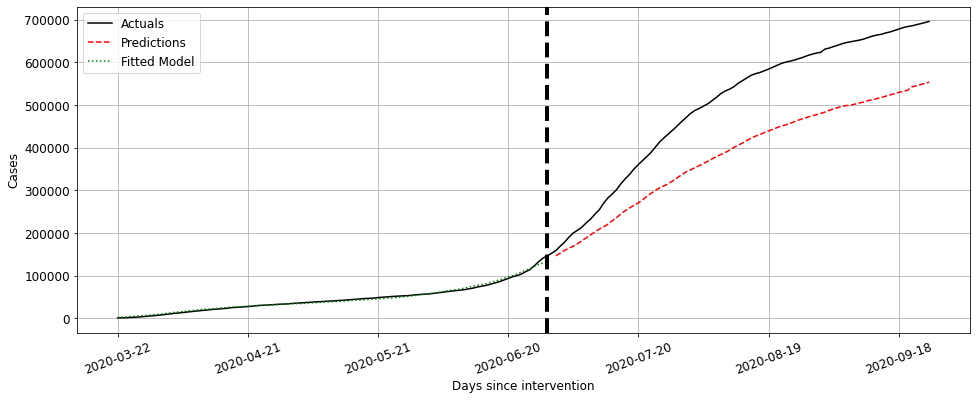

In [6]:
model.plot()

### Plot the diagram with donors' normalized weights

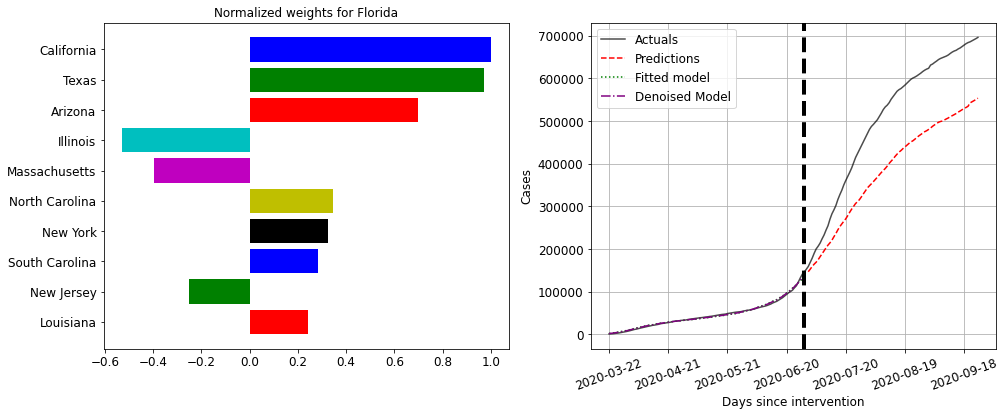

In [12]:
#donors_num will select the states with largest n absolute weight
model.plot(show_donors = True, show_denoise = True, donors_num = 10)

### Parameters that might be useful to know

In [8]:
print("Training error is %4.2f \nTesting error is %4.2f"%(model.train_err, model.test_err))

Training error is 8854856.36 
Testing error is 15682676841.10


### RI score for the target state

In [10]:
print("RI Score is %s"%(model.find_ri())) #RI score is defined as the test_err/train_err

RI Score is 1771.0820151636244


### Permutation distribution Diagram

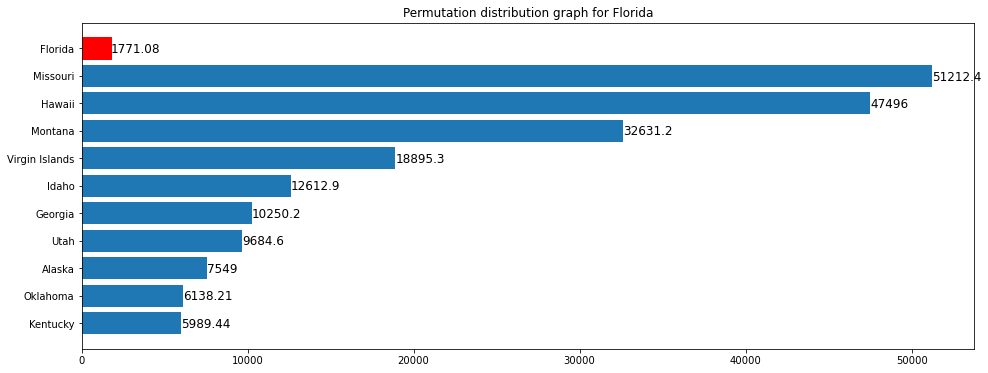

In [11]:
ri_dict = model.permutation_distribution(show_graph = True)

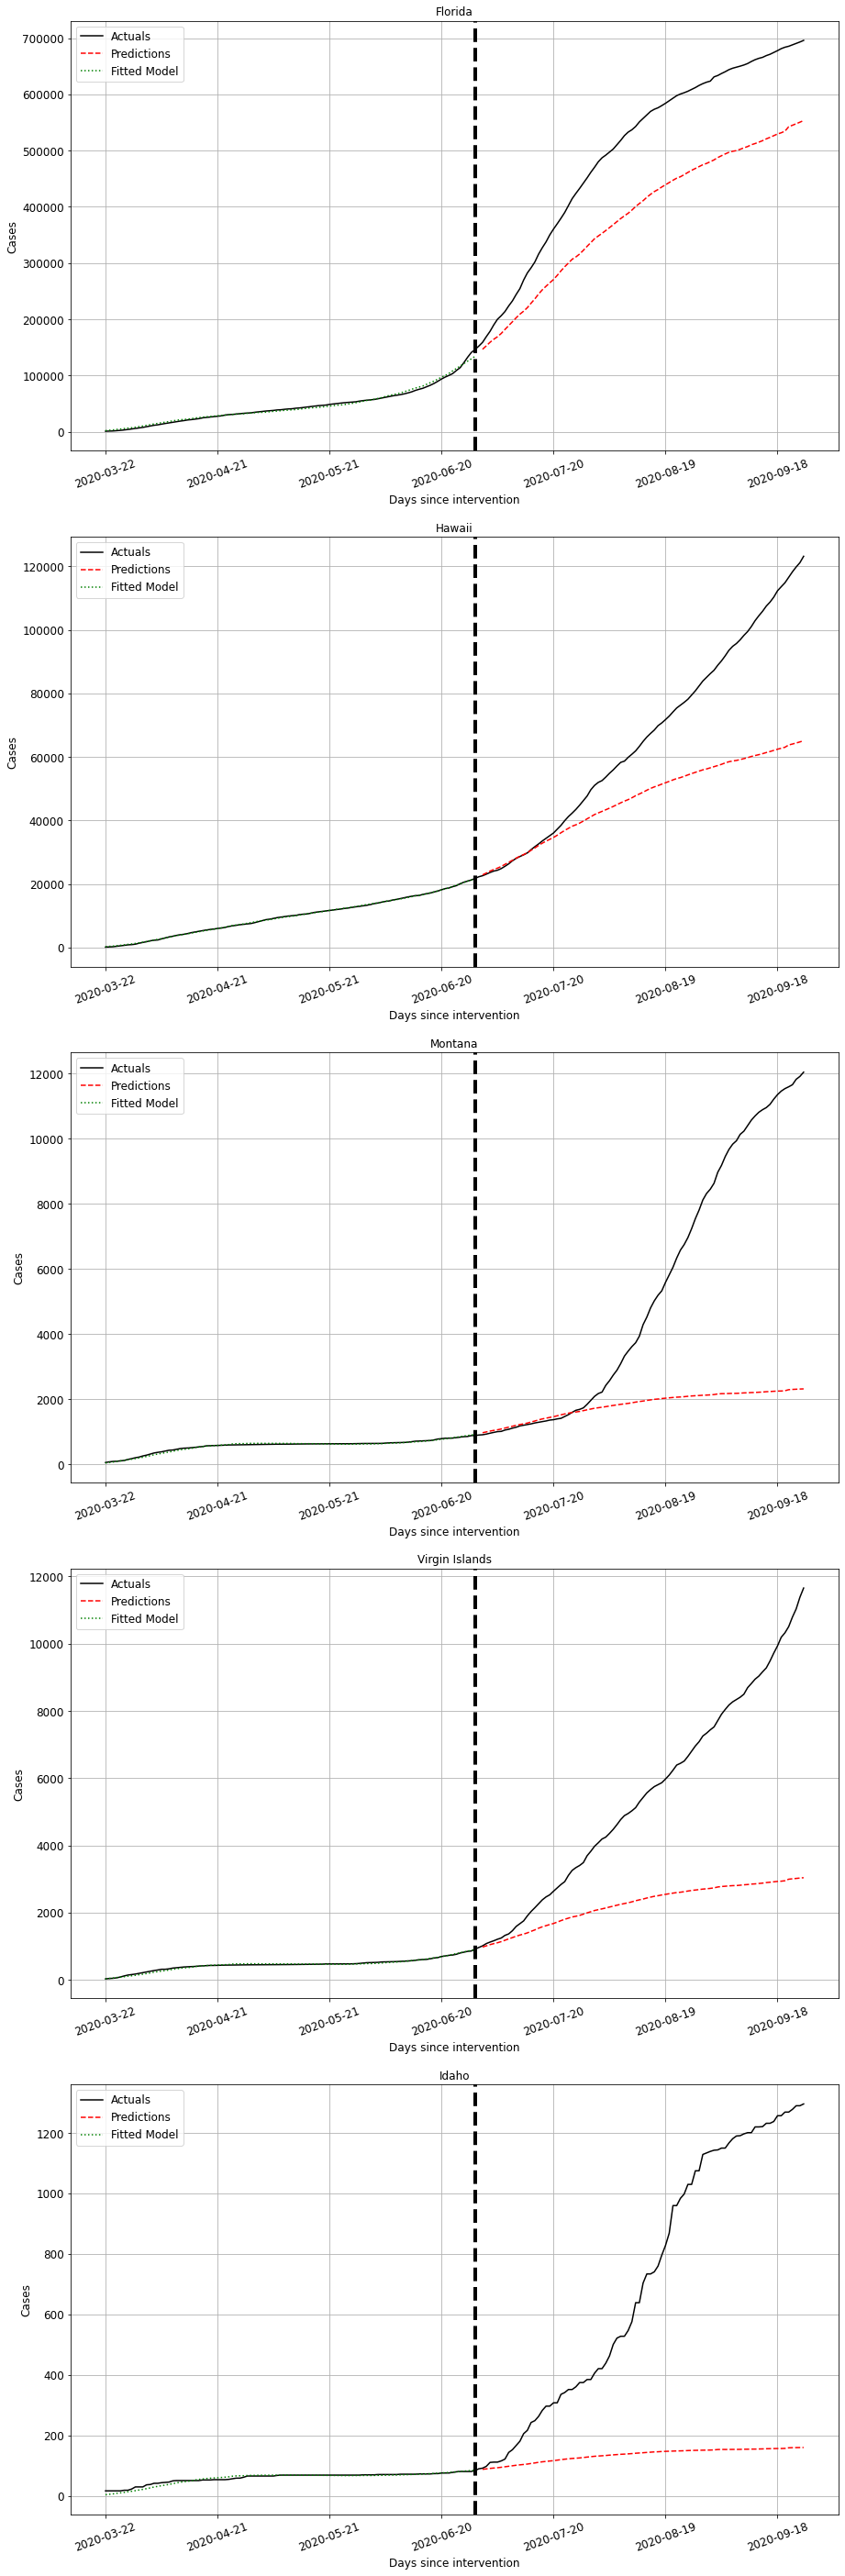

In [12]:
#Include the plot for the top 5 states with high ri score
ri_dict = model.permutation_distribution(show_graph = False, plot_models = 5)

In [ ]:
#the output of the function returns a all the ri score for the target states and states in the donors 
ri_dict

#### This short example is a bit handwaving - it is just an illustration of the class and functions. But, even without rigorously chosen of donor pool and the pre-intervention period, our model still shows that the cases increase in Florida after June 22 is much higher compared to all the other states. Now, let's be more rigorous in selecting our donor pool and treatment, and see if we can get other interesting findings. This leads to the second example,

## Examination of active intervention and herd immunity

#### Let's first load more data on county level time series

In [13]:
#Get county time series
counties = pd.read_csv(_NYTimes_local_path + "us-counties.csv")[1:]
counties['county_state'] = counties['county']+'-'+counties['state']
uscounties_cases = counties.pivot_table(index='date', columns='county_state', values='cases')
uscounties_cases = uscounties_cases.fillna(0)

#Let's also generate the average daily data
rolling_average_duration = 7
uscounties_cases_daily = uscounties_cases.diff()
uscounties_cases_daily[uscounties_cases_daily < 0] = 0 #
uscounties_cases_daily = uscounties_cases_daily.iloc[1:,:].rolling(rolling_average_duration).\
                            mean().iloc[rolling_average_duration:,:]

#### To acount for the difference in population density, we will normalize the counties cases by population. To do this, we will first clean the county population data.

In [14]:
_county_pop_local_path = "../data/population/co-est2019-annres.xlsx"
county_population = pd.read_excel(_county_pop_local_path, header=[3], skipfooter=6)
new = county_population['Unnamed: 0'].str.strip(".").str.replace(" County","").str.split(pat=",", expand=True)

county_population['county'] = new[0] +'-' + new[1].str.strip()
county_population['state']=new[1].str.strip()
county_population = county_population[['county', 2019, 'state']]
county_population = county_population.drop('state', axis = 1).dropna()
county_population.columns = ['name', 'value']
county_population['name'] = county_population['name'].str.replace(' Parish', '')
county_population = county_population.set_index('name')
county_population.rename(index={'New York-New York':'New York City-New York'},inplace=True)

#### Normalize the county data

In [15]:
def create_pop_adjusted(df, population):
    new_df = pd.DataFrame()
    exception_list = []
    for county in df:
        try:
            #We are calculating the cases per million in a given county
            new_df = pd.concat([new_df, 1000000 *df[county]/float(population.loc[county].value)], axis = 1, sort = True)
        except:
            exception_list.append(county)
    return new_df

#Create both the cumulative population scaled and the daily population scaled
uscounties_cases_pop = create_pop_adjusted(uscounties_cases, county_population)
uscounties_cases_daily_pop = create_pop_adjusted(uscounties_cases_daily, county_population)

#### Then, let's start the modeling. First, we can choose our donor pool state with active intervenetion. Most of them are from the North East state. For the treatment unit, we select Los Angeles-California.

In [17]:
donor_pool_state = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 
                    'Rhode Island', 'Vermont', 'New Jersey', 'New York']
target = "Los Angeles-California"

#Get the counties in our donor pool
donor_pool_county = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in donor_pool_state and names[0] != 'Unknown':
        donor_pool_county.append(counties)

#### One more thing we need to check is the intervention date. For this, let's first graph the spread of COVID in the donor pool, and spread in the treatment state.

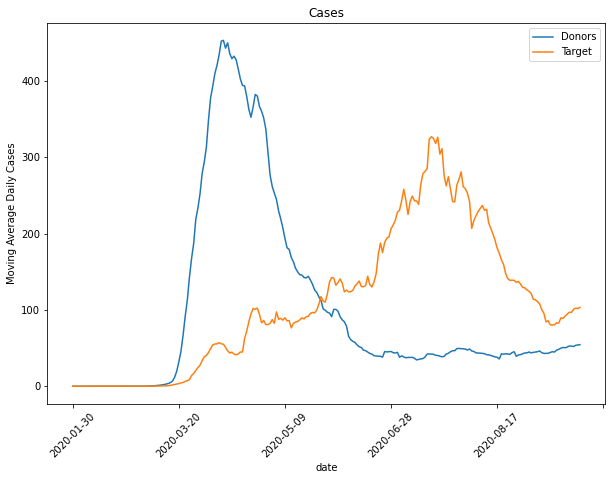

In [18]:
plt.rcParams['figure.figsize'] = (10, 7)

plot_dict = {'Donors': donor_pool_county,
             'Target': [target]}

dfplot = uscounties_cases_daily
for key in plot_dict:
    counties = plot_dict[key]

    (1000000*dfplot[counties].sum(axis=1)/(county_population[county_population.index.isin(counties)].value.sum())).plot(label = key)
    plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases'), plt.title('Cases'), plt.legend()
plt.show()

#### The places where the two lines cross is a reasonable date for the intervention date. Therefore, we choose the Memorial day as intervention date. Then, we have finalized all the parameters for our model. 

In [19]:
start_date = '2020-04-01' 
low_thresh_date = '2020-05-25' #Memorial Day

#Use the population normalized data

df = uscounties_cases_daily_pop.loc[start_date:]
df_pop = uscounties_cases_pop.loc[start_date:]
singVals = 4

tick_spacing=50
FONTSIZE = 18

#Pre-intervention
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days
#Total time span
high_thresh = df_pop.shape[0]


#### To take the herd immunity into account, we will select the counties with similar level of spread in the North-Eastern that we have identified as donor pool for our targeted counties. That is, if the number of cases on memorial day in the treatment state is $N$, we are selected the counties in North-Eastern that has the cases level on memorial day in the range $(0.5N, 1.5N)$

In [21]:

close_counties = df_pop.columns[(df_pop.iloc[low_thresh] < 1.5 * df_pop[target].iloc[low_thresh])&
                        (df_pop.iloc[low_thresh] > 0.5 * df_pop[target].iloc[low_thresh])]
donors = list(close_counties[close_counties.isin(donor_pool_county)])

#### Then, we can fit the model

In [22]:
target_model = syn_model(target, singVals, [df], high_thresh, low_thresh, otherStates=donors)
target_model.fit_model()

#### Similarly, we can fit another model with the counties that has the closest infection level on Memorial day as our target state.

In [23]:
close_state = donors[np.argmin(np.abs(df_pop[donors].iloc[low_thresh]-df_pop[target].iloc[low_thresh]))]
donors.remove(close_state)
donor_model = syn_model(close_state, singVals, [df], high_thresh, low_thresh, otherStates=donors)
donor_model.fit_model()

#### Finally, graph the two results.

(5.520248626706685, 342.0325300063933)

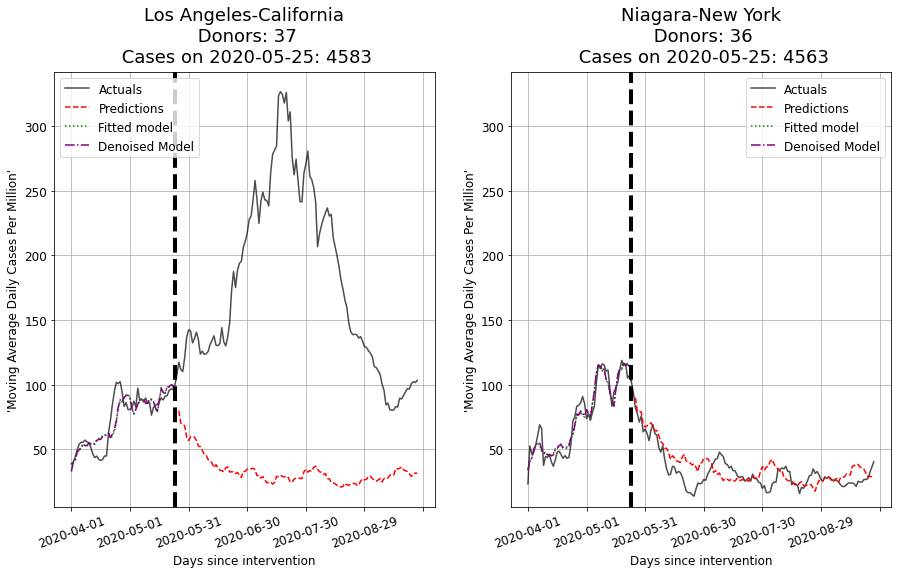

In [24]:
fig, axes = plt.subplots(1,2, figsize = (15, 8))

target_model.plot(axes = [axes[0]], show_denoise = True, figure = fig, yaxis = "'Moving Average Daily Cases Per Million'")


axes[0].set_title(target+"\n Donors: "+str(len(donors) + 1)
             + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[target].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)

y_min, y_max = axes[0].get_ylim()

donor_model.plot(axes = [axes[1]], show_denoise = True, figure = fig, yaxis = "'Moving Average Daily Cases Per Million'")

axes[1].set_title(close_state+"\n Donors: "+str(len(donors))
             + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[close_state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
axes[1].set_ylim([y_min, y_max])


## Conclusion
As we can see, the Eastern states closely follows the actual behavior, whereas, in Los Angeles, there is a significant departure (for the worse) from the counterfactual of theactual cases. This indicates that the policies implemented in the North-East states did have a significant effect on the spread ofthe virus, and the difference in behavior from the other counties cannot be explained by infection level or "herd immunity" alone.

The model presented here is a small part of the research we did, and the full paper can be found here: https://arxiv.org/abs/2009.09987